In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

import shap
from catboost import CatBoostRegressor, Pool

plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

pyplot.rcParams["figure.figsize"] = (20,10)

In [4]:
import matplotlib.pyplot as plt
def trading(forecast,actual):
#execute the trading from the result of forecast and actual energy production
#forecast: an 1D array of forecast values (Unit:kWh)
#actual: an 1D array of actual values (Unit:kWh)
  
    #initial budget
    budget=1e9
    #counters initialize: short falling and panalty counter
    SFcount=0;
    Pcount=0;
    cashFlow=[1e9]
    
    for f,a in zip(forecast,actual):
        if f <= a:
            budget += f*10
        elif f > a:#short falling
            #calculate cost of spot price energy
            budget += a*10
            spotP = 20*(f-a)
            SFcount+= 1
            if budget >= spotP:
                budget -= 20*(f-a)
            else:
                #receive penalty from the government
                if budget>0:
                    #buy from grid if budget not equal to 0
                    spotP-=budget
                    budget=0
                #fine =5* spotP
                budget -= 5*spotP
                Pcount+=1
        cashFlow.append(budget)
    timeStep= list(range(0, len(cashFlow)))
    #Reporting
    plt.plot(timeStep,cashFlow)
    plt.show()
    print ("resultant budget: ",budget)
    print ("net profit: ",budget-1e9)
    print ("number of short falling: ",SFcount )
    print ("number of panalty: ",Pcount )
    #print ("Cash flow: ",cashFlow )

In [5]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
data = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [7]:
data = data.drop_duplicates(subset=['datetime'])

In [8]:
data['datetime'] = data['datetime'].apply(lambda x: x.split("+")[0])

In [9]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [10]:
columns_use = ['datetime','Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [11]:
#agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])
#agg_df.columns = agg_df.columns.map('_'.join)
#agg_df = agg_df.reset_index()
#merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')
#merge_df = merge_df.fillna(method='ffill')

In [12]:
#data = merge_df.copy()

In [13]:
data = data[columns_use].fillna(method='ffill')

In [14]:
data.dropna(inplace=True)

In [15]:
window = 29 
lag_size = 18
lag = lag_size

In [16]:
series = series_to_supervised(data, window=window, lag=lag).reset_index(drop=True)

In [17]:
datetime_t0 = series['datetime(t)']

In [18]:
datetime_cols = [c for c in series.columns if 'datetime' in c]

In [19]:
series.drop(datetime_cols, axis=1, inplace=True)

In [20]:
series['datetime'] = datetime_t0

In [21]:
series['hour'] = series['datetime'].dt.hour
series['dayofweek'] = series['datetime'].dt.dayofweek
series['quarter'] = series['datetime'].dt.quarter
series['month'] = series['datetime'].dt.month
series['year'] = series['datetime'].dt.year 
series['dayofyear'] = series['datetime'].dt.dayofyear
series['dayofmonth'] = series['datetime'].dt.day
series['weekofyear'] = series['datetime'].dt.weekofyear

In [22]:
plt.rcParams["figure.figsize"] = (20, 9)

In [23]:
X_train = series[series.year.isin([2017,2018])].drop(columns=['datetime','year','month'])
X_test = series[series.year.isin([2019])].drop(columns=['datetime','year','month'])
X_holdout = series[series.year.isin([2020])].drop(columns=['datetime','year','month'])
y_train = series[series.year.isin([2017,2018])][['Wind(t+18)']]
y_test = series[series.year.isin([2019])][['Wind(t+18)']]
y_holdout = series[series.year.isin([2020])][['Wind(t+18)']]

In [24]:
leak_cols = [c for c in series.columns if '(t+%d)' % lag_size in c]

In [25]:
X_train.drop(leak_cols, axis=1, inplace=True)

X_test.drop(leak_cols, axis=1, inplace=True)

X_holdout.drop(leak_cols, axis=1, inplace=True)

In [26]:
reg = CatBoostRegressor(iterations = 1000, 
                        learning_rate = 0.01, 
                        loss_function = "RMSE",
                        max_depth = 1,
                        task_type = "GPU",
                        random_seed = 42
                       )

In [ ]:
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=50)

0:	learn: 3260.6169379	test: 5705.6391205	best: 5705.6391205 (0)	total: 11.1ms	remaining: 11.1s
1:	learn: 3245.8549273	test: 5685.7679405	best: 5685.7679405 (1)	total: 23.2ms	remaining: 11.6s
2:	learn: 3231.3206898	test: 5666.1674359	best: 5666.1674359 (2)	total: 35.5ms	remaining: 11.8s
3:	learn: 3217.0128046	test: 5646.8341316	best: 5646.8341316 (3)	total: 47ms	remaining: 11.7s
4:	learn: 3202.9272941	test: 5627.7647985	best: 5627.7647985 (4)	total: 58.4ms	remaining: 11.6s
5:	learn: 3189.0451001	test: 5607.6283437	best: 5607.6283437 (5)	total: 69.5ms	remaining: 11.5s
6:	learn: 3175.3892208	test: 5588.1365310	best: 5588.1365310 (6)	total: 81ms	remaining: 11.5s
7:	learn: 3161.9031100	test: 5569.7876461	best: 5569.7876461 (7)	total: 92.1ms	remaining: 11.4s
8:	learn: 3148.6290665	test: 5551.6897826	best: 5551.6897826 (8)	total: 103ms	remaining: 11.4s
9:	learn: 3135.5321848	test: 5532.5508163	best: 5532.5508163 (9)	total: 115ms	remaining: 11.4s
10:	learn: 3122.6418113	test: 5513.6729706	bes

90:	learn: 2468.6587143	test: 4517.3971618	best: 4517.3971618 (90)	total: 932ms	remaining: 9.31s
91:	learn: 2463.6980401	test: 4511.6486525	best: 4511.6486525 (91)	total: 942ms	remaining: 9.29s
92:	learn: 2458.7674092	test: 4500.5720547	best: 4500.5720547 (92)	total: 953ms	remaining: 9.29s
93:	learn: 2453.8394540	test: 4495.1108036	best: 4495.1108036 (93)	total: 962ms	remaining: 9.27s
94:	learn: 2449.0453321	test: 4489.5237508	best: 4489.5237508 (94)	total: 972ms	remaining: 9.26s
95:	learn: 2444.2539609	test: 4484.1823219	best: 4484.1823219 (95)	total: 981ms	remaining: 9.23s
96:	learn: 2439.4837669	test: 4473.4073652	best: 4473.4073652 (96)	total: 990ms	remaining: 9.22s
97:	learn: 2434.8518892	test: 4467.9778018	best: 4467.9778018 (97)	total: 1000ms	remaining: 9.2s
98:	learn: 2430.1819226	test: 4457.2564176	best: 4457.2564176 (98)	total: 1.01s	remaining: 9.19s
99:	learn: 2425.5655527	test: 4452.0825715	best: 4452.0825715 (99)	total: 1.02s	remaining: 9.18s
100:	learn: 2421.0138109	test:

181:	learn: 2168.4050365	test: 4009.7914948	best: 4009.7914948 (181)	total: 1.84s	remaining: 8.27s
182:	learn: 2166.3876186	test: 4005.1247983	best: 4005.1247983 (182)	total: 1.85s	remaining: 8.26s
183:	learn: 2164.3263868	test: 3998.9940089	best: 3998.9940089 (183)	total: 1.86s	remaining: 8.25s
184:	learn: 2162.3315588	test: 3996.4139980	best: 3996.4139980 (184)	total: 1.87s	remaining: 8.24s
185:	learn: 2160.3202714	test: 3990.3952200	best: 3990.3952200 (185)	total: 1.88s	remaining: 8.23s
186:	learn: 2158.2996315	test: 3988.3204226	best: 3988.3204226 (186)	total: 1.89s	remaining: 8.21s
187:	learn: 2156.3586738	test: 3985.9639257	best: 3985.9639257 (187)	total: 1.9s	remaining: 8.2s
188:	learn: 2154.3991384	test: 3980.0642295	best: 3980.0642295 (188)	total: 1.91s	remaining: 8.2s
189:	learn: 2152.4742244	test: 3977.6402971	best: 3977.6402971 (189)	total: 1.92s	remaining: 8.19s
190:	learn: 2150.5765200	test: 3974.9739583	best: 3974.9739583 (190)	total: 1.93s	remaining: 8.17s
191:	learn: 2

269:	learn: 2043.7760647	test: 3761.9317286	best: 3761.9317286 (269)	total: 2.74s	remaining: 7.41s
270:	learn: 2042.8317353	test: 3760.8585602	best: 3760.8585602 (270)	total: 2.75s	remaining: 7.4s
271:	learn: 2041.9333643	test: 3759.5954047	best: 3759.5954047 (271)	total: 2.76s	remaining: 7.39s
272:	learn: 2041.0158026	test: 3758.5434669	best: 3758.5434669 (272)	total: 2.77s	remaining: 7.38s
273:	learn: 2040.1585960	test: 3756.8265937	best: 3756.8265937 (273)	total: 2.78s	remaining: 7.37s
274:	learn: 2039.2545740	test: 3753.0567009	best: 3753.0567009 (274)	total: 2.79s	remaining: 7.36s
275:	learn: 2038.3739054	test: 3749.9018572	best: 3749.9018572 (275)	total: 2.8s	remaining: 7.35s
276:	learn: 2037.4853938	test: 3748.8768875	best: 3748.8768875 (276)	total: 2.81s	remaining: 7.34s
277:	learn: 2036.6248636	test: 3747.8304259	best: 3747.8304259 (277)	total: 2.82s	remaining: 7.33s
278:	learn: 2035.7676466	test: 3745.3392257	best: 3745.3392257 (278)	total: 2.83s	remaining: 7.32s
279:	learn: 

357:	learn: 1986.4422822	test: 3629.4224068	best: 3629.4224068 (357)	total: 3.64s	remaining: 6.53s
358:	learn: 1985.9759178	test: 3628.8468101	best: 3628.8468101 (358)	total: 3.65s	remaining: 6.52s
359:	learn: 1985.5187508	test: 3628.2792419	best: 3628.2792419 (359)	total: 3.66s	remaining: 6.51s
360:	learn: 1985.0778578	test: 3627.7591508	best: 3627.7591508 (360)	total: 3.67s	remaining: 6.5s
361:	learn: 1984.6234305	test: 3627.2257061	best: 3627.2257061 (361)	total: 3.69s	remaining: 6.5s
362:	learn: 1984.1877615	test: 3626.2443394	best: 3626.2443394 (362)	total: 3.7s	remaining: 6.49s
363:	learn: 1983.7532938	test: 3624.5476287	best: 3624.5476287 (363)	total: 3.71s	remaining: 6.48s
364:	learn: 1983.3179054	test: 3624.0538417	best: 3624.0538417 (364)	total: 3.72s	remaining: 6.46s
365:	learn: 1982.8824213	test: 3623.3795660	best: 3623.3795660 (365)	total: 3.73s	remaining: 6.45s
366:	learn: 1982.4436558	test: 3621.1494977	best: 3621.1494977 (366)	total: 3.74s	remaining: 6.44s
367:	learn: 1

In [ ]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(Pool(X_train, y_train))

# feature importance plot
shap.summary_plot(shap_values[:100], X_train, plot_type="bar")

In [26]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (70043, 996, 1)
Validation set shape (35036, 996, 1)


In [27]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [28]:
reg = Sequential()
reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
reg.add(MaxPooling1D(pool_size=2))
reg.add(Flatten())
reg.add(Dense(50, activation='relu'))
reg.add(Dense(1))
reg.compile(loss='mse', optimizer=adam)
reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 995, 64)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 497, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31808)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1590450   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,590,693
Trainable params: 1,590,693
Non-trainable params: 0
_________________________________________________________________


In [29]:
cnn_history = reg.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
2189/2189 - 20s - loss: 4125627.5000 - val_loss: 9879846.0000
Epoch 2/40
2189/2189 - 20s - loss: 3950007.5000 - val_loss: 9899299.0000
Epoch 3/40
2189/2189 - 20s - loss: 3880296.2500 - val_loss: 10058475.0000
Epoch 4/40
2189/2189 - 20s - loss: 3839445.7500 - val_loss: 9537155.0000
Epoch 5/40
2189/2189 - 20s - loss: 3794644.5000 - val_loss: 9485338.0000
Epoch 6/40
2189/2189 - 20s - loss: 3765412.7500 - val_loss: 9502279.0000
Epoch 7/40
2189/2189 - 20s - loss: 3718595.7500 - val_loss: 10673452.0000
Epoch 8/40
2189/2189 - 20s - loss: 3697195.2500 - val_loss: 10209407.0000
Epoch 9/40
2189/2189 - 20s - loss: 3663166.5000 - val_loss: 9567339.0000
Epoch 10/40
2189/2189 - 20s - loss: 3651142.7500 - val_loss: 9653809.0000
Epoch 11/40
2189/2189 - 20s - loss: 3629631.2500 - val_loss: 9575438.0000
Epoch 12/40
2189/2189 - 20s - loss: 3619610.2500 - val_loss: 9391269.0000
Epoch 13/40
2189/2189 - 20s - loss: 3609095.2500 - val_loss: 9339645.0000
Epoch 14/40
2189/2189 - 20s - loss: 3599007.

In [33]:
y_pred = reg.predict(X_test_series)

In [34]:
np.sqrt(mean_squared_error(y_test,y_pred))

3056.4275402790886

In [35]:
mean_absolute_error(y_test,y_pred)

2191.647902619017

In [36]:
test_result = series[series.year.isin([2019])].copy()
test_result['prediction'] = y_pred

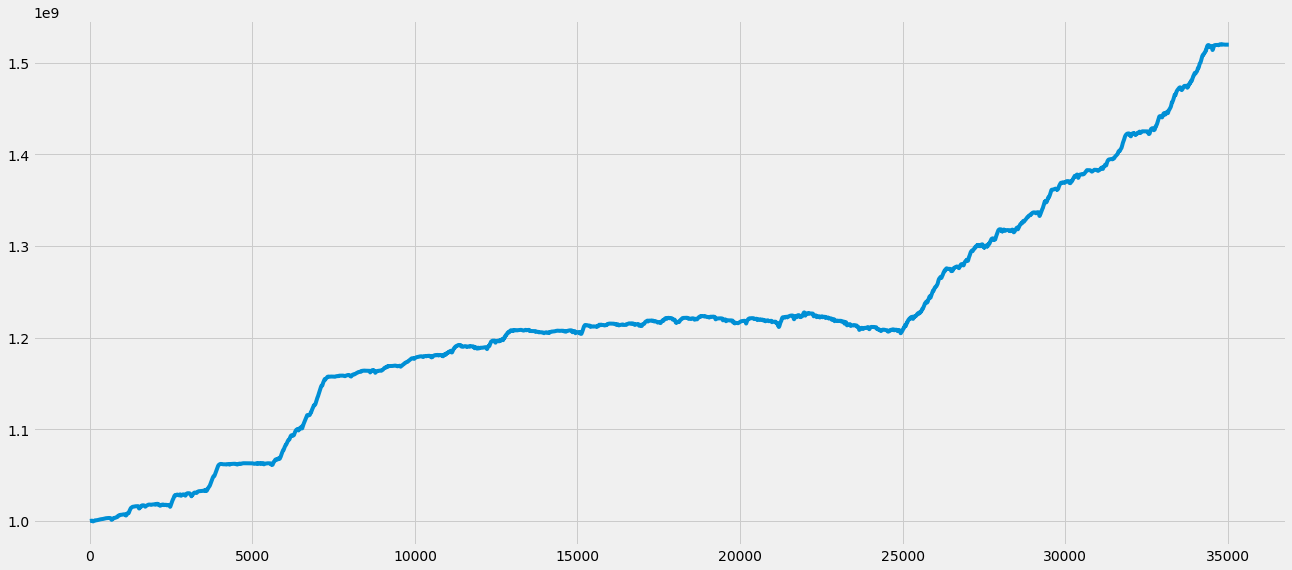

resultant budget:  1519657430.5494483
net profit:  519657430.54944825
number of short falling:  17245
number of panalty:  0


In [37]:
trading(test_result['Wind(t+18)'], test_result.prediction)

In [39]:
test_result['wind_baseline']  = data.Wind.mean()

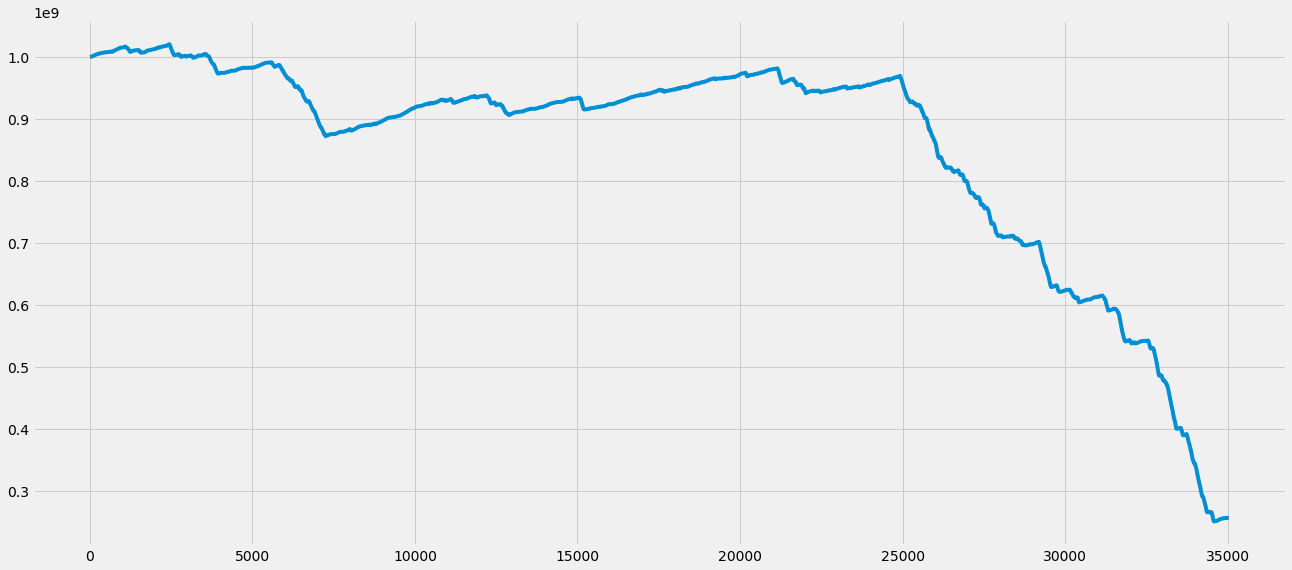

resultant budget:  256858933.63037205
net profit:  -743141066.369628
number of short falling:  15202
number of panalty:  0


In [40]:
trading(test_result['Wind(t+18)'], test_result.wind_baseline)